In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
% matplotlib inline

# 2.4.4 NY Crime Linear Regression Model

Use a multivariate linear regression model to predict **property crimes** in New York. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Data: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

## Import and prepare data

In [35]:
df = pd.read_csv('nyc_crime.csv', header=4, skipfooter=3, engine='python')
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0.0,NaN
1,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0.0,NaN
2,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0.0,NaN
3,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN,NaN
4,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN,NaN


In [36]:
# Do some light cleaning/reorg

# remove extra column
del df['Unnamed: 13']

# rename columns
df.columns = ['city', 'population', 'violent_crimes', 'murder', 'rape1', 'rape2', 'robbery', 'assault', 'property', 
              'burglary', 'larceny_theft', 'vehicle_theft', 'arson']

# delete rape1 - this column doesn't tell us any information.  All rape data in rape2 column.
del df['rape1']

In [37]:
# Check dtypes
#print(df.dtypes)

# Remove commas 
column_names = ['city', 'population', 'violent_crimes', 'murder', 'rape2', 'robbery', 'assault', 'property', 
              'burglary', 'larceny_theft', 'vehicle_theft', 'arson']

for column in column_names:
    df[column] = df[column].apply(lambda x: str(x).replace(',', ''))

# Convert to numeric
numeric_columns = ['population', 'violent_crimes', 'murder', 'rape2', 'robbery', 'assault', 'property', 
              'burglary', 'larceny_theft', 'vehicle_theft']

for column in numeric_columns:
    df[column] = pd.to_numeric(df[column])

# Confirm changes
#print(df.dtypes)

In [38]:
# Remove arson column.  Too many missing fields to impute data.  Based on footnote in raw excel file, NaN fields represent
# cities where the data reporting wasn't done properly.

del df['arson']

## Prepare data to input in model using the following regression:
$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [39]:
#square population
df['sq_population'] = df['population'] **2

#Encode murder data as categorical
df['murder_mod'] = 0
df.loc[df['murder'] > 0, 'murder_mod'] = 1

#Encode robbery data as categorical
df['robbery_mod'] = 0
df.loc[df['robbery'] > 0, 'robbery_mod'] = 1

## Explore Variables

#### Dependent Variable

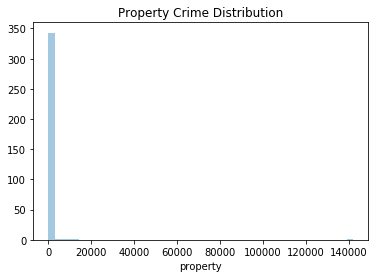

In [40]:
# Distribution of target variable property crimes
g = sns.distplot(df.property, kde=False)
plt.title('Property Crime Distribution')
plt.show()

# NYC data is an extremely large outlier skewing the data

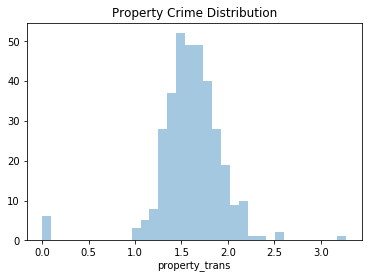

In [41]:
# Try a transform on the data
df['property_trans'] = df['property']**0.1
g = sns.distplot(df.property_trans, kde=False)
plt.title('Property Crime Distribution')
plt.show()

# Looks normal-ish now.  Remember to transform the model output by using (output value)^10

In [42]:
df.loc[df['city'] == 'New York']

,city,population,violent_crimes,murder,rape2,robbery,assault,property,burglary,larceny_theft,vehicle_theft,sq_population,murder_mod,robbery_mod,property_trans
216,New York,8396126,52384,335,1112,19170,31767,141971,16606,117931,7434,70494931807876,1,1,3.275065


In [43]:
# Try creating new dataframe without NYC data
df2 = df.drop(df.index[216])
df2.describe()

,population,violent_crimes,murder,rape2,robbery,assault,property,burglary,larceny_theft,vehicle_theft,sq_population,murder_mod,robbery_mod,property_trans
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,3.470000e+02,347.000000,347.000000,347.000000
mean,15956.685879,51.213256,0.605187,2.677233,17.867435,30.063401,385.752161,72.172911,298.994236,14.585014,9.858407e+08,0.138329,0.599424,1.602527
std,27080.218837,236.667435,3.707090,10.741020,94.972492,128.783376,1034.369072,264.941381,715.232296,67.682236,5.067232e+09,0.345743,0.490723,0.332781
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.766760e+05,0.000000,0.000000,0.000000
25%,2997.000000,2.000000,0.000000,0.000000,0.000000,1.000000,40.000000,6.000000,31.000000,0.000000,8.982153e+06,0.000000,0.000000,1.446085
50%,7187.000000,6.000000,0.000000,0.000000,1.000000,4.000000,112.000000,17.000000,94.000000,2.000000,5.165297e+07,0.000000,1.000000,1.602957
75%,18160.500000,21.500000,0.000000,2.000000,5.000000,14.000000,340.500000,51.000000,284.500000,7.000000,3.298042e+08,0.000000,1.000000,1.791479
max,258789.000000,3249.000000,47.000000,145.000000,1322.000000,1735.000000,12491.000000,3458.000000,8076.000000,957.000000,6.697175e+10,1.000000,1.000000,2.568383


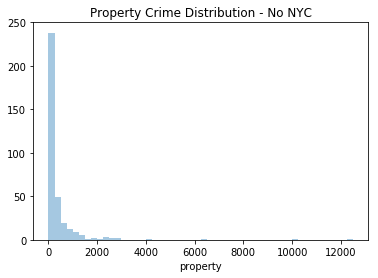

In [44]:
# Plot distribution w/out NYC
g = sns.distplot(df2.property, kde=False)
plt.title('Property Crime Distribution - No NYC')
plt.show()

# Still very unbalanced

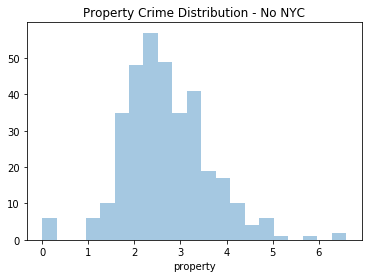

In [45]:
# Try a transform w/out NYC
x = df2.property**0.2
g = sns.distplot(x, kde=False)
plt.title('Property Crime Distribution - No NYC')
plt.show()

In [46]:
# Doesn't look much better. Leave in NYC data and use property_trans column.

# Update:  Models were much worse using property_trans column.  Models below were run using original property values.
# could have to do with needing to transform the model output before evaluating error?  How would this be done?  Would you 
# transform the 'predicted' variable?

#### Independent Variables

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [47]:
# Follow given model 
X = df[['population', 'sq_population', 'murder_mod', 'robbery_mod']]

In [48]:
# Look at correlation between variables 
correlation_matrix = X.corr()
display(X.corr())

,population,sq_population,murder_mod,robbery_mod
population,1.000000,0.998264,0.162309,0.064371
sq_population,0.998264,1.000000,0.133067,0.043983
murder_mod,0.162309,0.133067,1.000000,0.313271
robbery_mod,0.064371,0.043983,0.313271,1.000000


In [49]:
# Try using given model with untransformed property crime data

# Instantiate and fit.
regr = linear_model.LinearRegression()
Y = df['property']
X = df[['population', 'sq_population', 'murder_mod', 'robbery_mod']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [  3.46570268e-02  -2.11108019e-09   1.51866535e+01  -9.62774363e+01]

Intercept: 
 -109.575335623

R-squared:
0.996124710499


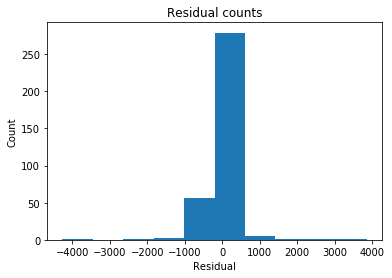

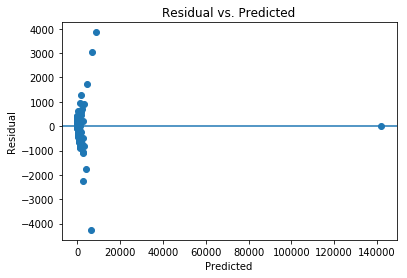

In [50]:
# Model gives good R^2 value.  Look at distribution of error

# What is .ravel() doing?  

predicted = regr.predict(X).ravel()
#predicted = regr.predict(X)
actual = df['property']

residual = actual - predicted

# Plot distribution of error
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Plot distribution of error 
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [51]:
# Run model without NYC data.  Same model parameters.
df2.head(1)

,city,population,violent_crimes,murder,rape2,robbery,assault,property,burglary,larceny_theft,vehicle_theft,sq_population,murder_mod,robbery_mod,property_trans
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,3463321,0,0,1.282089


In [52]:
# Instantiate and fit.
regr = linear_model.LinearRegression()
Y = df2['property']
X = df2[['population', 'sq_population', 'murder_mod', 'robbery_mod']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [  1.29510871e-02   1.14920528e-07   1.95038666e+02   9.28205845e+01]

Intercept: 
 -16.8158663217

R-squared:
0.844493761117


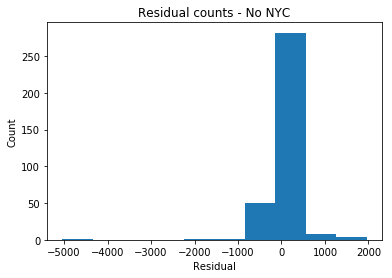

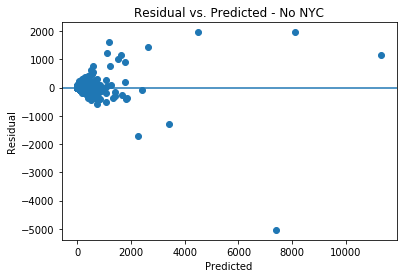

In [53]:
# Look at distribution of error

predicted = regr.predict(X).ravel()
actual = df2['property']

residual = actual - predicted

# Plot distribution of error
plt.hist(residual)
plt.title('Residual counts - No NYC')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Plot distribution of error 
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted - No NYC')
plt.show()

In [54]:
# Including NYC data makes R^2 value larger but magnitude of residual error is also larger. 